# Iceberg

In [1]:
import urllib
import pandas as pd
import numpy as np


class Iceberg:
    
    def __init__(self, id_num, datetimes, lats, lons, size):
        self.id_num = id_num
        self.datetimes = datetimes
        self.lats = lats
        self.lons = lons
        self.size = size
        self.length, self.width, self.height = self.get_berg_dims(size)
        
            
    def get_berg_dims(self, size):
        # Size must be GR, BB, SM, MED, LG, VLG, or a list of [l, w, h]
        # See https://nsidc.org/data/g00807 for more info
        
        if type(size) == list and len(size) == 3:
            l, w, h = size[0], size[1], size[2]
        
        elif type(size) == str:
            if size == 'GR':
                l = (0+5)/2; w = (0+5)/2; h = (0+1)/2*10
            elif size == 'BB':
                l = (5+15)/2; w = (5+15)/2; h = (1+5)/2*10        
            elif size == 'SM':
                l = (15+60)/2; w = (15+60)/2; h = (5+15)/2*10        
            elif size == 'MED':
                l = (60+120)/2; w = (60+120)/2; h = (15+45)/2*10               
            elif size == 'LG':
                l = (120)/2; w = (120)/2; h = (45+75)/2*10                
            elif size == 'VLG':
                # Sizes have no listed upper bound
                l = (200+200/2)/2; w = (200+200/2)/2; h = (75+75/2)/2*10     
            # This info for GEN is wrong!
            elif size == 'GEN':
                l = (120)/2; w = (120)/2; h = (45+75)/2*10            
            else:
                print('unknown size class')
                l = None; w = None; h = None
                
        return l, w, h

In [2]:
def get_berg_df(chosen_track_ind):

    # Choose iceberg year (2002 - 2015 available)
    # Note: Iceberg Season starts in November so many datasets include dates from year-1
    season_year = 2015
    iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
    iip_filename = 'IIP_{}IcebergSeason.csv'.format(season_year)
    iip_url = iip_url_base + iip_filename
    r = urllib.request.urlretrieve(iip_url)
    iip_df = pd.read_csv(r[0], converters={'TIME':str})
    iip_df['TIMESTAMP'] = pd.to_datetime(iip_df['DATE'] + 'T' + iip_df['TIME'])


    # Choose the min number of observations for an eligible iceberg
    min_num_obs = 10
    eligible_bergs = np.asarray(
        iip_df['BERG_NUMBER'].value_counts()\
        .loc[iip_df['BERG_NUMBER'].value_counts() > min_num_obs].index)

    chosen_inds_arr = []

    for i in range(eligible_bergs.size):

        iip_berg_id = eligible_bergs[i]
        iip_berg_df = iip_df.loc[iip_df['BERG_NUMBER'] == iip_berg_id]
        
        ind0 = iip_berg_df.index.tolist()[0]
        indf = iip_berg_df.index.tolist()[-1]
        
        max_time_dif = np.timedelta64(24*60, 'm')
        
        chosen_inds = []

        for j in range(len(iip_berg_df)-1):

            time_dif = (iip_berg_df.TIMESTAMP.values[j+1] - \
                        iip_berg_df.TIMESTAMP.values[j]).astype('timedelta64[m]')
            
            if time_dif < max_time_dif:
                chosen_inds.append(j+ind0)

            elif len(chosen_inds) > 1:
                chosen_inds_arr.append(chosen_inds)
                chosen_inds = []
            else:
                chosen_inds = []

        if len(chosen_inds) > 1:
            chosen_inds_arr.append(chosen_inds)

    iip_berg_df = iip_df.loc[chosen_inds_arr[chosen_track_ind]].reset_index()

    return iip_berg_df

In [3]:
chosen_track_ind = 0

In [4]:
iip_berg_df = get_berg_df(chosen_track_ind)

In [5]:
iip_berg_df

index  ICE-YEAR  BERG_NUMBER       DATE  TIME  LATITUDE  LONGITUDE METHOD  \
0   6319      2015        21511  6/16/2015  1442     48.16     -50.01    R/V   
1   6320      2015        21511  6/17/2015  1300     48.09     -50.02    R/V   
2   6321      2015        21511  6/18/2015  1249     48.08     -49.76    VIS   

  SIZE SHAPE SOURCE           TIMESTAMP  
0   LG   TAB   GTJZ 2015-06-16 14:42:00  
1   LG   GEN   GMRS 2015-06-17 13:00:00  
2   LG   TAB   GTJZ 2015-06-18 12:49:00

In [6]:
iip_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                iip_berg_df['LATITUDE'].loc[:].tolist(),
                iip_berg_df['LONGITUDE'].loc[:].tolist(),
                iip_berg_df['SIZE'].loc[0])

In [7]:
iip_berg_df['TIMESTAMP'].dt.to_pydatetime()

array([datetime.datetime(2015, 6, 16, 14, 42),
       datetime.datetime(2015, 6, 17, 13, 0),
       datetime.datetime(2015, 6, 18, 12, 49)], dtype=object)

# Metocean

In [8]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy.interpolate as interp
import datetime
from datetime import date, timedelta
import urllib


class Metocean(object):

    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        self.x_min = x_min - abs(x_min-x_max) - self.xy_res
        self.x_max = x_max + abs(x_min-x_max) + self.xy_res
        self.y_min = y_min - abs(y_min-y_max) - self.xy_res
        self.y_max = y_max + abs(y_min-y_max) + self.xy_res
        self.t_min = t_min - timedelta(hours = self.t_res)
        self.t_max = t_max + timedelta(hours = self.t_res)

                                           
    
    def convert_datetime2time(self, t, t_units, t_calendar, t_offset=0):
                                                
        dt += timedelta(hours = t_offset)
        t = nc.date2num(t, t_units, t_calendar)
        
        return t



class ECMWF_Ocean(Metocean):
    
    # product identifier: GLOBAL_ANALYSIS_FORECAST_PHY_001_024

    path = 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/'
    xy_res = 1/12  # spatial resolution in degrees lat/lon
    t_res = 1  # temporal resolution in hours
    t_units = 'hours since 1950-01-01 00:00:00'
    t_calendar = 'standard'
    
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        
        self.filenames, self.files = self.get_filenames(self.t_min, self.t_max, self.path)
        self.ds = nc.MFDataset(self.files)
        self.times = self.ds.variables['time'][:]
        self.datetimes = nc.num2date(self.times, self.t_units, self.t_calendar)
        self.t1900 = nc.date2num(self.datetimes, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        self.t1950 = nc.date2num(self.datetimes, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        self.t2000 = nc.date2num(self.datetimes, 'hours since 2000-01-01 00:00:00.0 00:00', 'standard')
        self.lats = self.ds.variables['latitude'][:]
        self.lons = self.ds.variables['longitude'][:]
        self.UW = np.asarray(self.ds.variables['uo'][:,0,:,:])
        self.VW = np.asarray(self.ds.variables['vo'][:,0,:,:])
        self.SST = np.asarray(self.ds.variables['thetao'][:,0,:,:])
        self.iUW = interp.RegularGridInterpolator((self.times, self.lats, self.lons), self.UW)
        self.iVW = interp.RegularGridInterpolator((self.times, self.lats, self.lons), self.VW)
        self.iSST = interp.RegularGridInterpolator((self.times, self.lats, self.lons), self.SST)


    
    def get_filenames(self, t_min, t_max, path):

        d1 = date(self.t_min.year, self.t_min.month, self.t_min.day)  # start date
        d2 = date(self.t_max.year, self.t_max.month, self.t_max.day)  # end date
        delta = d2 - d1  # timedelta

        filenames = []
        files = []

        for i in range(delta.days + 1):
            new_date = d1 + timedelta(days=i)
            filenames.append(path + str(new_date).replace('-', '') + '.nc')
            files.append(urllib.request.urlretrieve(filenames[i])[0])

        return filenames, files



class ECMWF_Atm(Metocean):
    
    # product identifier: WIND_GLO_WIND_L4_NRT_OBSERVATIONS_012_004
    path = 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/'
    xy_res = 1/4  # spatial resolution in degrees lat/lon
    t_res = 6  # temporal resolution in hours
    t_units = 'hours since 1900-01-01 00:00:00.0 00:00'
    t_calendar = 'standard'
    
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        
        self.filenames, self.files = self.get_filenames(self.t_min, self.t_max, self.path)
        self.ds = nc.MFDataset(self.files)
        self.times = self.ds.variables['time'][:]
        self.datetimes = nc.num2date(self.times, self.t_units, self.t_calendar)
        self.t1900 = nc.date2num(self.datetimes, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')
        self.t1950 = nc.date2num(self.datetimes, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
        self.t2000 = nc.date2num(self.datetimes, 'hours since 2000-01-01 00:00:00.0 00:00', 'standard')
        self.lats = self.ds.variables['latitude'][:]
        self.lons = self.ds.variables['longitude'][:]
        self.UA = np.asarray(self.ds.variables['eastward_wind'][:,0,:,:])
        self.VA = np.asarray(self.ds.variables['northward_wind'][:,0,:,:])
        self.iUA = interp.RegularGridInterpolator((self.times, self.lats, self.lons), self.UA)
        self.iVA = interp.RegularGridInterpolator((self.times, self.lats, self.lons), self.VA)
        

    def get_filenames(self, t_min, t_max, path):

        d1 = date(self.t_min.year, self.t_min.month, self.t_min.day)  # start date
        d2 = date(self.t_max.year, self.t_max.month, self.t_max.day)  # end date
        delta = d2 - d1  # timedelta

        filenames = []
        files = []

        for i in range(delta.days + 1):
            new_date = d1 + timedelta(days=i)
            filenames.append(path + 'sub' + str(new_date).replace('-', '') + '.nc')
            files.append(urllib.request.urlretrieve(filenames[i])[0])

        return filenames, files

In [9]:
ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [10]:
ocean_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150618.nc']

In [11]:
atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.datetimes[0], iip_berg.datetimes[-1])

In [12]:
atm_data.filenames

['ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150616.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150617.nc',
 'ftp://data.munroelab.ca/pub/ECMWF/atm/daily/sub20150618.nc']

# Wagner wrapper

In [22]:
import numpy as np
import cmath

# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2



def wagner_drift(x, y, l, w, h, AU, AV, WU, WV, SST, t_ocean, t_atm, dt):


    # Extract values from input fields
    
    vau = AU([t_atm, y, x])[0]
    vav = AV([t_atm, y, x])[0]  
    vwu = WU([t_ocean, y, x])[0] 
    vwv = WV([t_ocean, y, x])[0]
    sst = SST([t_ocean, y, x])[0]
    
    
    # Drift

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)

    
    if lam < 0.1:
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

        
    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))


    # Decay

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new
        
    return x_new, y_new, l_new, w_new, h_new

In [14]:
iip_berg.datetimes

array([datetime.datetime(2015, 6, 16, 14, 42),
       datetime.datetime(2015, 6, 17, 13, 0),
       datetime.datetime(2015, 6, 18, 12, 49)], dtype=object)

In [23]:
# Timesteps

t0 = iip_berg.datetimes[0]
tf = iip_berg.datetimes[-1]

t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step_hours = 0.1
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)



berg_sizes = ['GR', 'BB', 'SM', 'MED', 'LG', 'VLG']
bergs_by_size = []

plot_list = []

for berg_size in berg_sizes:
    

    
    mod_berg = Iceberg(iip_berg_df['BERG_NUMBER'][0],
                        iip_berg_df['TIMESTAMP'].dt.to_pydatetime(),
                        [iip_berg_df['LATITUDE'][0]],
                        [iip_berg_df['LONGITUDE'][0]],
                        berg_size)
    
    
    mod_berg.length = [mod_berg.length]
    mod_berg.width = [mod_berg.width]
    mod_berg.height = [mod_berg.height]
    
    # Iceberg Initial Location
    x0, y0 = mod_berg.lons[0], mod_berg.lats[0]

    # Run number
    run_num = 0
    num_runs = 1

    # Buffer number for bounding spatial box
    buf = 0.5

    # Initialize output dict
    output_dict = {}

    for run_num in range(num_runs):

        # Iceberg Initials
        l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
        l0 = l0 + l0*0.1*run_num
        w0 = w0 + w0*0.1*run_num
        h0 = h0 + h0*0.1*run_num
        l, w, h = l0, w0, h0
        x, y = x0, y0

        print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))
        
        for t in t_all:
            
                
            t_ocean = nc.date2num(t, 'hours since 1950-01-01 00:00:00.0 00:00', 'standard')
            t_atm = nc.date2num(t, 'hours since 1900-01-01 00:00:00.0 00:00', 'standard')

            #print('Timestep: {}'.format(t))

            x_new, y_new, l_new, w_new, h_new = wagner_drift(x, y, l, w, h, 
                                                             atm_data.iUA, atm_data.iVA, 
                                                             ocean_data.iUW, ocean_data.iVW, 
                                                             ocean_data.iSST, 
                                                             t_ocean, t_atm, dt)

            if x_new > max(iip_berg.lons)+buf or x_new < min(iip_berg.lons)-buf or \
               y_new > max(iip_berg.lats)+buf or y_new <= min(iip_berg.lats)-buf:
                # Iceberg out-of-bounds
                print('out-of-bounds')
                break


            if l_new <= 0 or w_new <= 0 or h_new <= 0:
                # Iceberg melted
                print('melted')
                break

            else:
                x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
                mod_berg.lons.append(x)
                mod_berg.lats.append(y)
                mod_berg.length.append(l)
                mod_berg.width.append(w)
                mod_berg.height.append(h)


    print("Final time: {}".format(t)) 
    bergs_by_size.append(mod_berg)

Run number: 0, h = 5.0, l = 2.5, w = 2.5
rollover
swap l and w
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
rollover
melted
Final time: 2015-06-17 22:24:00
Run number: 0, h = 30.0, l = 10.0, w = 10.0
rollover
swap l and w
rollover
rollover
Final time: 2015-06-18 12:54:00
Run number: 0, h = 100.0, l = 37.5, w = 37.5
rollover
swap l and w
Final time: 2015-06-18 12:54:00
Run number: 0, h = 300.0, l = 90.0, w = 90.0
rollover
swap l and w
Final time: 2015-06-18 12:54:00
Run number: 0, h = 600.0, l = 60.0, w = 60.0
rollover
swap l and w
Final time: 2015-06-18 12:54:00
Run number: 0, h = 562.5, l = 150.0, w = 150.0
rollover
swap l and w
Final time: 2015-06-18 12:54:00


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import bisect
from matplotlib.animation import FuncAnimation

In [19]:
import os
%matplotlib inline
plt.style.use('default')
from matplotlib.backends.backend_pdf import PdfPages

In [20]:
def plot_return_size_vary_no_time(iip_berg, mod_berg_gr, mod_berg_bb, mod_berg_sm, mod_berg_med, 
                         mod_berg_lg, mod_berg_vlg, ind=None):
    f = plt.figure()

    plt.plot(iip_berg.lons, iip_berg.lats, label='observed', color='red')
    plt.plot(mod_berg_gr.lons, mod_berg_gr.lats, label='gr', color='orange')
    plt.plot(mod_berg_bb.lons, mod_berg_bb.lats, label='bb', color='green')
    plt.plot(mod_berg_sm.lons, mod_berg_sm.lats, label='sm', color='blue')
    plt.plot(mod_berg_med.lons, mod_berg_med.lats, label='med', color='black')
    plt.plot(mod_berg_lg.lons, mod_berg_lg.lats, label='lg', color='purple')
    plt.plot(mod_berg_vlg.lons, mod_berg_vlg.lats, label='vlg', color='yellow')
    plt.legend()
    plt.xlabel('Longitude'); plt.ylabel('Latitude')

    return f

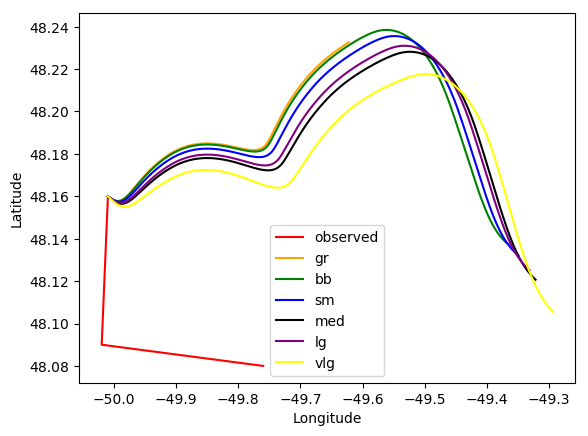

In [21]:

plot = plot_return_size_vary_no_time(iip_berg, bergs_by_size[0], bergs_by_size[1],
                            bergs_by_size[2],bergs_by_size[3],bergs_by_size[4],
                            bergs_by_size[5], chosen_track_ind)

plot_list.append(plot)
if not os.path.exists('plots'):
    os.makedirs('plots')
with PdfPages('plots/plots_size_vary.pdf') as pdf:
    for plot in plot_list:
        pdf.savefig(plot)